In [42]:
import sys
import os
from matplotlib.colors import LinearSegmentedColormap
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
from pathlib import Path
import glob
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
from utils.ccf_utils import ccf_pts_convert_to_mm, pir_to_lps, project_to_plane
from utils.combine_tools import apply_qc, to_str_intlike, spatial_dependence_summary, binary_shift_P_vs_U, welch_shift_P_vs_U
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import r2_score
import warnings
from scipy.stats import gaussian_kde
import trimesh
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from utils.ccf_utils import ccf_pts_convert_to_mm
from trimesh import load_mesh
from scipy.stats import pearsonr
import statsmodels.api as sm
from aind_ephys_utils import align
import k3d
from scipy.stats import rankdata
from scipy.ndimage import binary_dilation
from skimage.measure import find_contours
warnings.filterwarnings('ignore')

%matplotlib inline

# Load data

In [43]:
criteria_name = 'beh_all'
beh_criteria = 'beh_all_beh'
version = 'PrL_S1'

In [44]:
# load waveforms
waveform_criteria = 'waveform_all'
waveform_type = '_raw'
wf_folder  = os.path.join('/root/capsule/scratch/combined/wf_plots', waveform_criteria, waveform_type)
wf_feature_file = os.path.join(wf_folder, 'wf_features_combined.pkl')
with open(wf_feature_file, 'rb') as f:
    wf_features = pickle.load(f)
wf_features.rename(columns={'unit': 'unit_id'}, inplace=True)
wf_features['unit_id'] = wf_features['unit_id'].apply(to_str_intlike)
wf_features.drop(columns=['probe'], inplace=True)

In [45]:
# load basic ephys
be_criteria = 'basic_ephys'
be_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', be_criteria)
be_file = os.path.join(be_folder, f'basic_ephys.pkl')
with open(be_file, 'rb') as f:
    basic_ephys_df = pickle.load(f)
filter = basic_ephys_df['be_filter'].values
filter = np.array(filter, dtype=bool)
basic_ephys_df['be_filter'] = filter
basic_ephys_df.rename(columns={'unit': 'unit_id'}, inplace=True)
basic_ephys_df['unit_id'] = basic_ephys_df['unit_id'].apply(to_str_intlike)

In [46]:
# load basic constraints and data (unit + behavior)
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
combined_tagged_units.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units['unit_id'] = combined_tagged_units['unit_id'].apply(to_str_intlike)
# behavior 
with open(os.path.join('/root/capsule/scratch/combined/combined_session_tbl', 'combined_beh_sessions.pkl'), 'rb') as f:
    combined_session_qc = pickle.load(f)
combined_session_qc.drop(columns=['probe'], inplace=True, errors='ignore')
combined_tagged_units = combined_tagged_units.merge(combined_session_qc, on='session', how='left')

# antidromic data
antidromic_file = f'/root/capsule/scratch/combined/beh_plots/basic_ephys_low/{version}/combined_antidromic_results.pkl'
with open(antidromic_file, 'rb') as f:
    antidromic_df = pickle.load(f)

antidromic_df.rename(columns={'unit': 'unit_id'}, inplace=True)
antidromic_df['unit_id'] = antidromic_df['unit_id'].apply(to_str_intlike)
antidromic_df = antidromic_df[['unit_id', 'session', 'p_auto_inhi', 't_auto_inhi',
       'p_collision', 't_collision', 'p_antidromic', 't_antidromic', 'tier_1',
       'tier_2', 'tier_1_long', 'tier_2_long']].copy()
combined_tagged_units = combined_tagged_units.merge(antidromic_df, on=['session', 'unit_id'], how='left')
combined_tagged_units['tier_1'].fillna(False, inplace=True)
combined_tagged_units['tier_2'].fillna(False, inplace=True)
combined_tagged_units['tier_1_long'].fillna(False, inplace=True)
combined_tagged_units['tier_2_long'].fillna(False, inplace=True)

with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{beh_criteria}.json'), 'r') as f:
    beh_constraints = json.load(f)
beh_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', criteria_name)
if not os.path.exists(beh_folder):
    os.makedirs(beh_folder)
# start with a mask of all True
mask = pd.Series(True, index=combined_tagged_units.index)

Applying conditional bounds for isi_violations
 - isi_violations: 18300 -> 8349 units passed
Applying items for qc_pass: [True]
 - qc_pass: 8349 -> 5876 units passed
Applying bounds for peak: [-1000, 500]
 - peak: 5876 -> 5853 units passed
Applying items for in_df: [True]
 - in_df: 5853 -> 4219 units passed
Applying conditional bounds for y_loc
 - y_loc: 4219 -> 2956 units passed
Applying bounds for trial_count: [100, 2000]
 - trial_count: 2956 -> 2942 units passed
Applying bounds for sd: [0, 0.3]
 - sd: 2942 -> 1355 units passed
Applying opto conditions: ['p_max', 'eu', 'corr', 'tag_loc', 'lat_max_p', 'p_mean', 'sig_counts']
Number of opto units after filtering: 309
Number of non-opto units after filtering: 1355


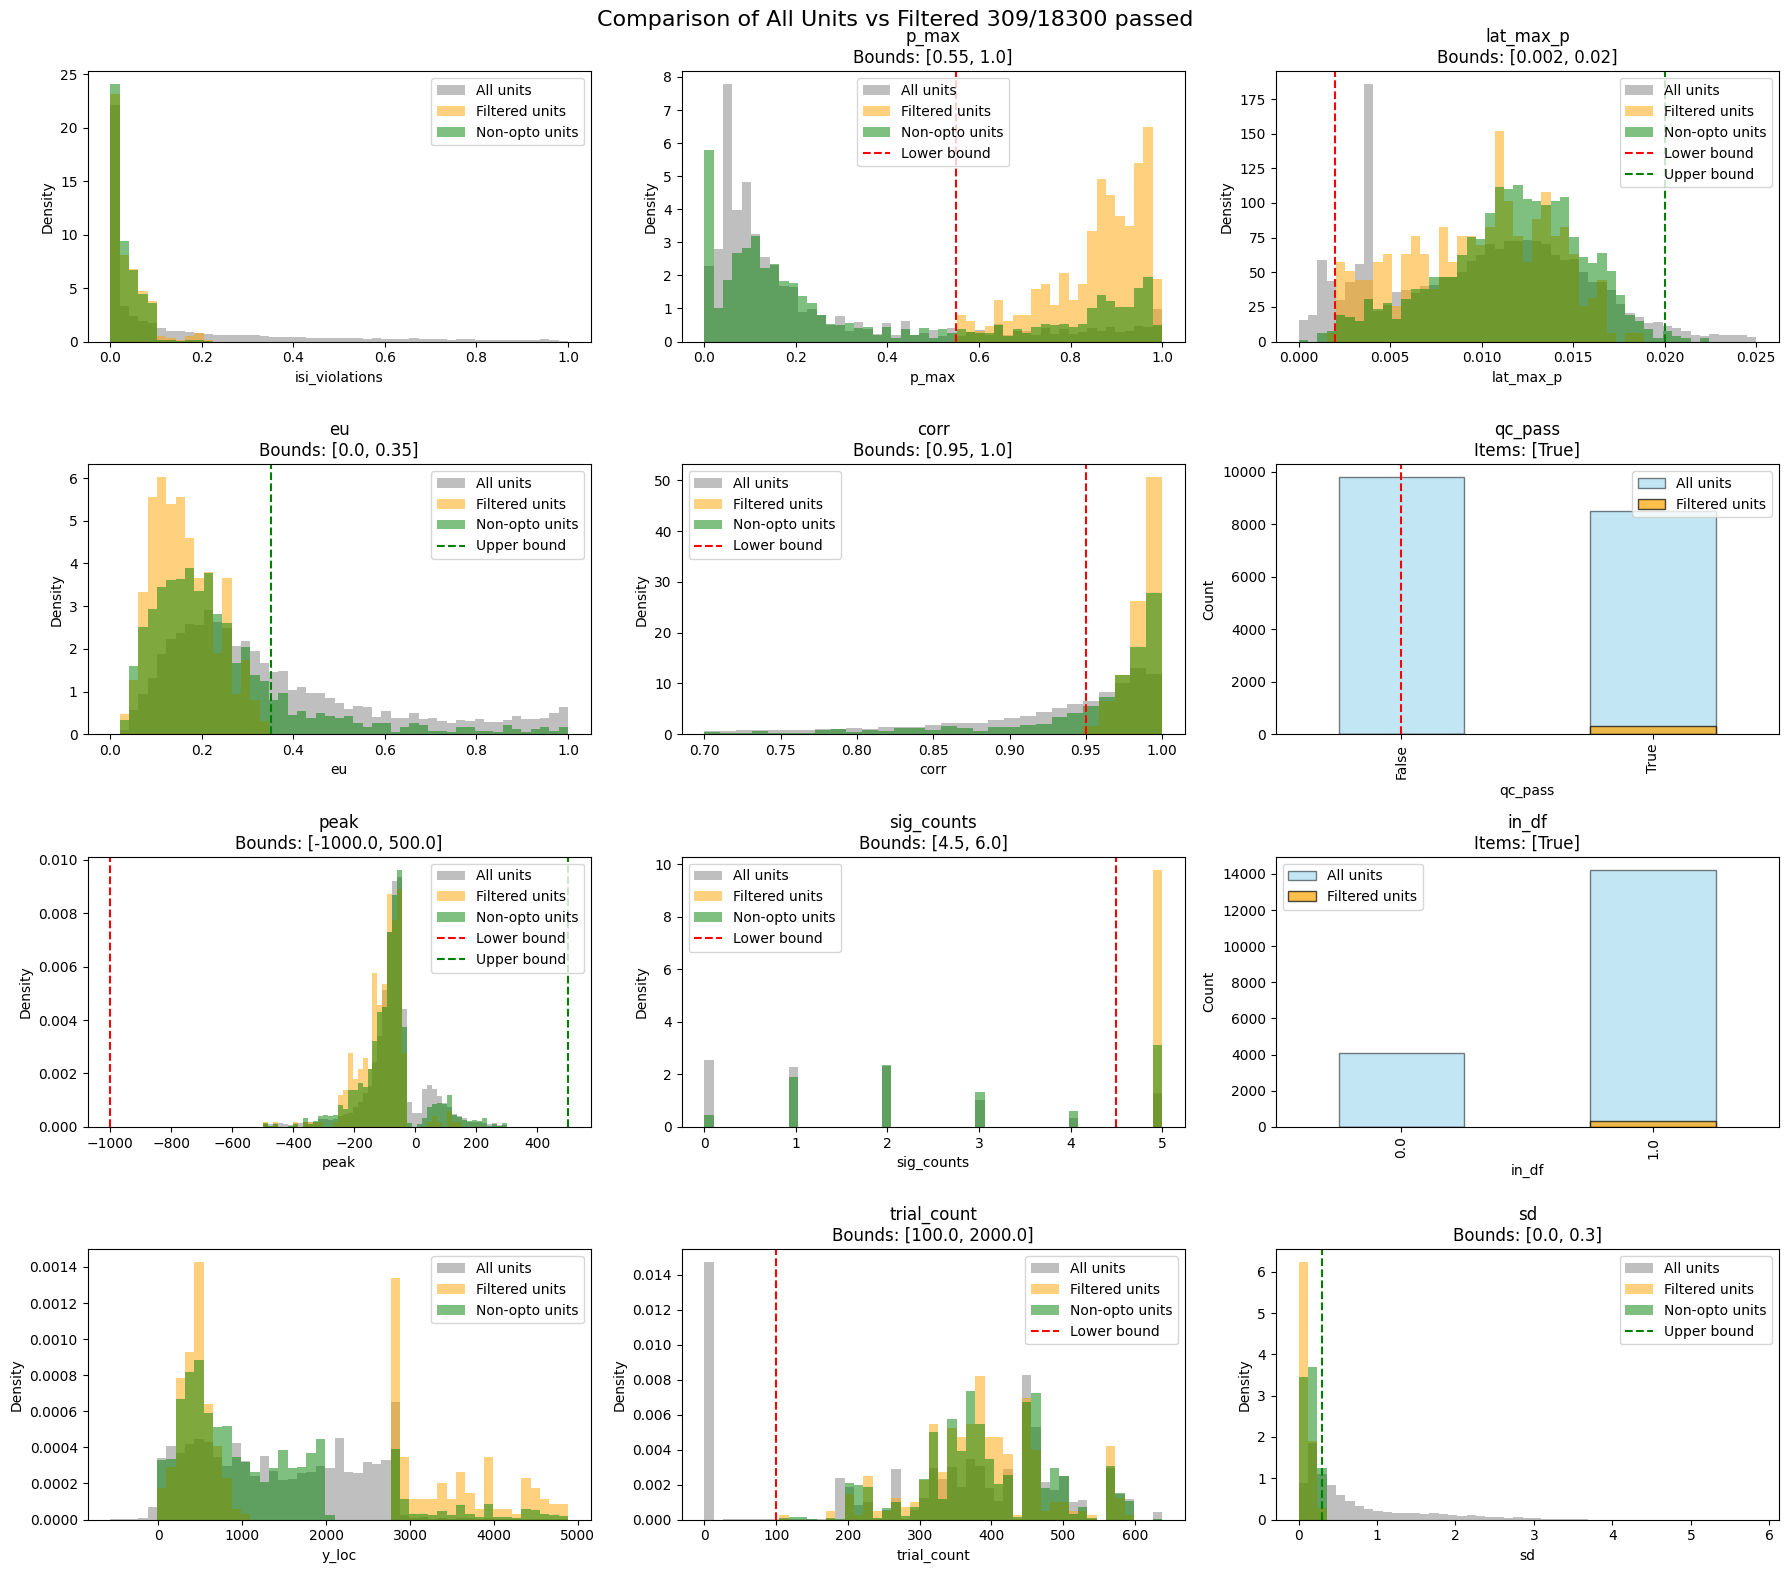

In [47]:
combined_tagged_units_filtered, combined_tagged_units, fig = apply_qc(combined_tagged_units, constraints)
combined_tagged_units.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units['unit_id'] = combined_tagged_units['unit_id'].apply(to_str_intlike)
combined_tagged_units_filtered.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units_filtered['unit_id'] = combined_tagged_units_filtered['unit_id'].apply(to_str_intlike)

Applying bounds for isi_violations: [0.0, 0.1]
 - isi_violations: 18300 -> 8322 units passed
Applying items for qc_pass: [True]
 - qc_pass: 8322 -> 5849 units passed
Applying bounds for peak: [-1000, 500]
 - peak: 5849 -> 5826 units passed
Applying items for in_df: [True]
 - in_df: 5826 -> 4194 units passed
Applying conditional bounds for y_loc
 - y_loc: 4194 -> 2931 units passed
Applying bounds for trial_count: [100, 2000]
 - trial_count: 2931 -> 2919 units passed
Applying bounds for session_len: [100, 2000]
 - session_len: 2919 -> 2770 units passed
Applying bounds for p_sw_L: [0.05, 1]
 - p_sw_L: 2770 -> 2656 units passed
Applying bounds for aN: [0.05, 1.0]
 - aN: 2656 -> 2654 units passed
Applying bounds for diff_1: [0, 'nan']
 - diff_1: 2654 -> 2654 units passed
Applying bounds for intercept: [-3, 3]
 - intercept: 2654 -> 2605 units passed
Applying bounds for sw_bias: [-1, 1]
 - sw_bias: 2605 -> 2605 units passed
Applying items for lick_bias: [False]
 - lick_bias: 2605 -> 2020 unit

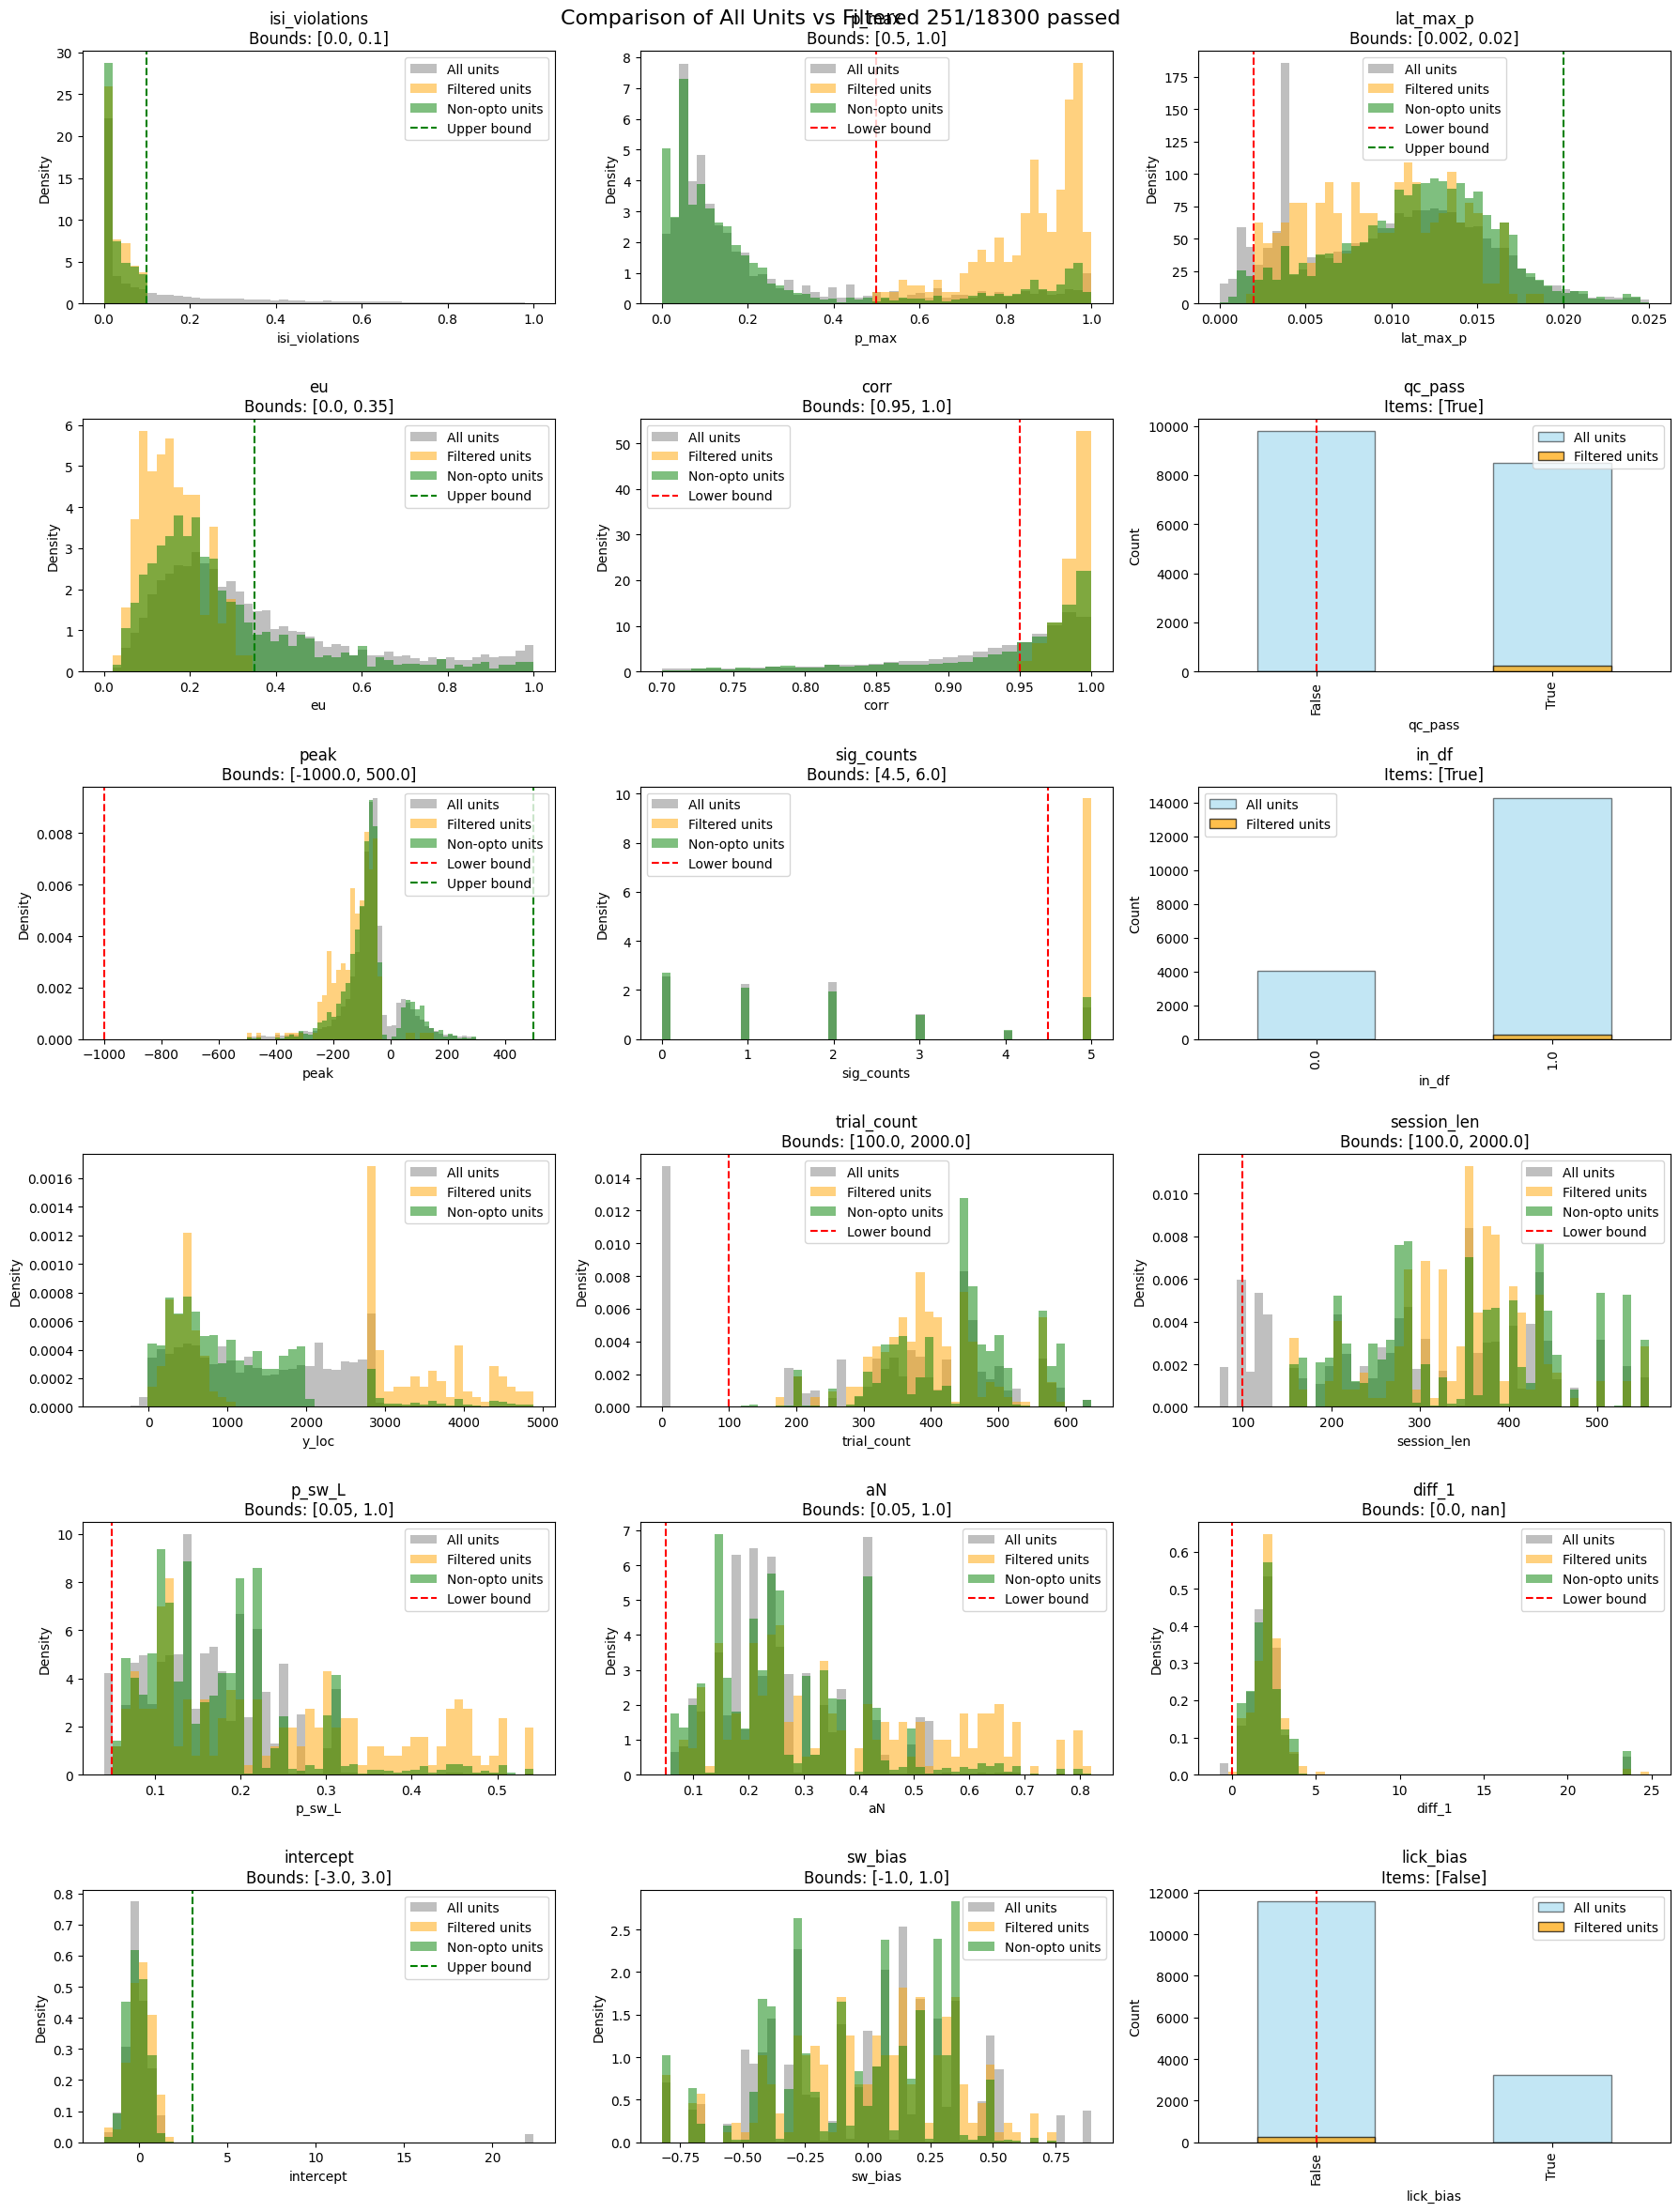

In [48]:
combined_tagged_units_filtered_beh, combined_tagged_units_beh, fig = apply_qc(combined_tagged_units, beh_constraints)

In [49]:
combined_tagged_units_beh.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units_beh['unit_id'] = combined_tagged_units_beh['unit_id'].apply(to_str_intlike)

In [50]:
# load and add model variables
model_combined = pd.read_csv(os.path.join(beh_folder, 'figures_in_generation', f'model_combined_{criteria_name}.csv'), index_col=0)
model_combined['theta'] = model_combined['theta'] - 0.5
model_combined['unit_id'] = model_combined['unit_id'].apply(to_str_intlike)

versions = ['e', 'l', 'com']
for version in versions:
    all_vec = np.column_stack((
        model_combined[f'coef_outcome_{version}_mc'],
        model_combined[f'coef_Qchosen_{version}_ori']
    ))
    theta, rho = np.arctan2(all_vec[:, 1], all_vec[:, 0]), np.hypot(all_vec[:, 1], all_vec[:, 0])
    bound_1, bound_2, bound_3 = -(1 / 4) * np.pi, np.pi, -np.pi
    theta_scaled_dis = np.zeros_like(theta)
    for ind, angle_curr in enumerate(theta):
        if bound_1 < angle_curr <= bound_2:
            theta_scaled_dis[ind] = (angle_curr - bound_1) / (bound_2 - bound_1)
        else:
            theta_scaled_dis[ind] = (bound_1 - angle_curr) / (bound_1 - bound_3)
    theta_scaled_dis_all = 1 - theta_scaled_dis - 0.5
    model_combined[f'theta_{version}'] = theta_scaled_dis_all

# derived features
model_combined['coef_outcome|(|coef_outcome| + |coef_Q|)'] = (
    model_combined['coef_outcome_com_mc'] /
    (np.abs(model_combined['coef_outcome_com_mc']) + np.abs(model_combined['coef_Qchosen_com_mc']))
)
model_combined['outcome_ipsi'] = (
    model_combined['coef_outcome_com_mc'] + model_combined['coef_outcome:ipsi_com_mc']
)
model_combined['outcome_contra'] = (
    model_combined['coef_outcome_com_mc'] - model_combined['coef_outcome:ipsi_com_mc']
)
model_combined = model_combined.merge(combined_tagged_units_beh[['session', 'unit_id', 'selected']], on=['session', 'unit_id'], how='left')
# model_combined = model_combined[model_combined['selected']]

In [76]:
# Combine all features
features_combined = pd.merge(model_combined, wf_features, on=['session', 'unit_id'], suffixes=('', '_wf'), how='outer')
features_combined = pd.merge(features_combined, basic_ephys_df, on=['session', 'unit_id'], suffixes=('', '_be'), how='outer')
response_tbl = pd.read_csv(f'/root/capsule/scratch/combined/beh_plots/beh_all/response_ratio_beh_all_go_cue.csv')
response_tbl['unit_id'] = response_tbl['unit'].apply(to_str_intlike)
features_combined = features_combined.merge(response_tbl, on=['session', 'unit_id'], how='outer')

# features_combined = features_combined.merge(antidromic_df, on=['session', 'unit_id'], how='outer')
features_combined = features_combined.merge(combined_tagged_units[['session', 'unit_id', 'probe', 'x_ccf', 'y_ccf', 'z_ccf', 'tier_1', 'tier_2', 'isi_violations', 'sd']], on=['session', 'unit_id'], how='right')
features_combined['be_filter'].fillna(False, inplace=True)
features_combined['selected'].fillna(False, inplace=True)
# filter with combined_tagged_units_filtered
# keep if session, unit in combined_tagged_units_filtered
mask_filtered = features_combined.set_index(['session', 'unit_id']).index.isin(
    combined_tagged_units_filtered.set_index(['session', 'unit_id']).index
)
features_combined = features_combined[mask_filtered].copy()

In [78]:
# save
output_file = os.path.join(target_folder, f'features_combined_{criteria_name}.pkl')
with open(output_file, 'wb') as f:
    pickle.dump(features_combined, f)

In [79]:
target_folder = '/root/capsule/scratch/manuscript/F_ephys_beh_action&outcome'
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

# Plot features in space

In [80]:
from matplotlib.colors import Normalize
ml, ap, dv = 0, 1, 2
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}

norm = Normalize(vmin=0, vmax=1)
mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices = (mesh_vertices - np.array([216, 18, 228]))*25/1000
mesh_vertices_lps = pir_to_lps(mesh_vertices) # convert to lps
mesh_vertices_mm = mesh_vertices_lps
# mesh_vertices_mm[:, ml] = -mesh_vertices_mm[:, ml]

In [81]:
# precompute mesh contours for each plane (for speed)
mesh_contours = {
    plane_name: project_to_plane(mesh_vertices_mm, plane_axes, pitch=0.02, margin=0.5)
    for plane_name, plane_axes in planes.items()
}

In [82]:
# colormaps
reward_colors = LinearSegmentedColormap.from_list('outcome', [(0.0, 'red'), (0.5, 'white'), (1.0, 'blue')])
hit_colors = LinearSegmentedColormap.from_list('hit', [(0.0, 'blue'), (0.5, 'white'), (1.0, 'orange')])
switch_colors = LinearSegmentedColormap.from_list('switch', [(0.0, 'green'), (0.5, 'white'), (1.0, 'purple')])

In [85]:
feature_map = {
'T_baseline_svs_hit': switch_colors,
'T_response_svs_hit': switch_colors,
'T_outcome_com_mc': reward_colors,
'T_outcome_l_mc': reward_colors, 
'T_baseline_hit_all': hit_colors, 
'T_response_hit_all': hit_colors
}

In [86]:
# perform spatial dependence analysis for all features
spatial_dependence_results = {}
for feature_name, _ in feature_map.items():
    values = features_combined[feature_name].values
    result = spatial_dependence_summary(
        ccfs,
        values,
        k_neighbors=30,
        n_splits=5,
        permutations=5000,
        seed=42,
    )
    spatial_dependence_results[feature_name] = result


In [87]:

# multiple comparison correction (FDR)
from statsmodels.stats.multitest import multipletests
# for knn
p_values = [spatial_dependence_results[feat]['cv_predictability_knn']['p_value_permutation'] for feat in feature_map.keys()]
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
for i, feature_name in enumerate(feature_map.keys()):
    spatial_dependence_results[feature_name]['cv_predictability_knn']['p_value_permutation_fdr'] = pvals_corrected[i]
    spatial_dependence_results[feature_name]['cv_predictability_knn']['significant_fdr'] = reject[i]
# for trend
p_values = [spatial_dependence_results[feat]['linear_trend']['p_value_F_test_vs_intercept_only'] for feat in feature_map.keys()]
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
for i, feature_name in enumerate(feature_map.keys()):
    spatial_dependence_results[feature_name]['linear_trend']['p_value_F_test_vs_intercept_only_fdr'] = pvals_corrected[i]
    spatial_dependence_results[feature_name]['linear_trend']['significant_fdr'] = reject[i]
# save results

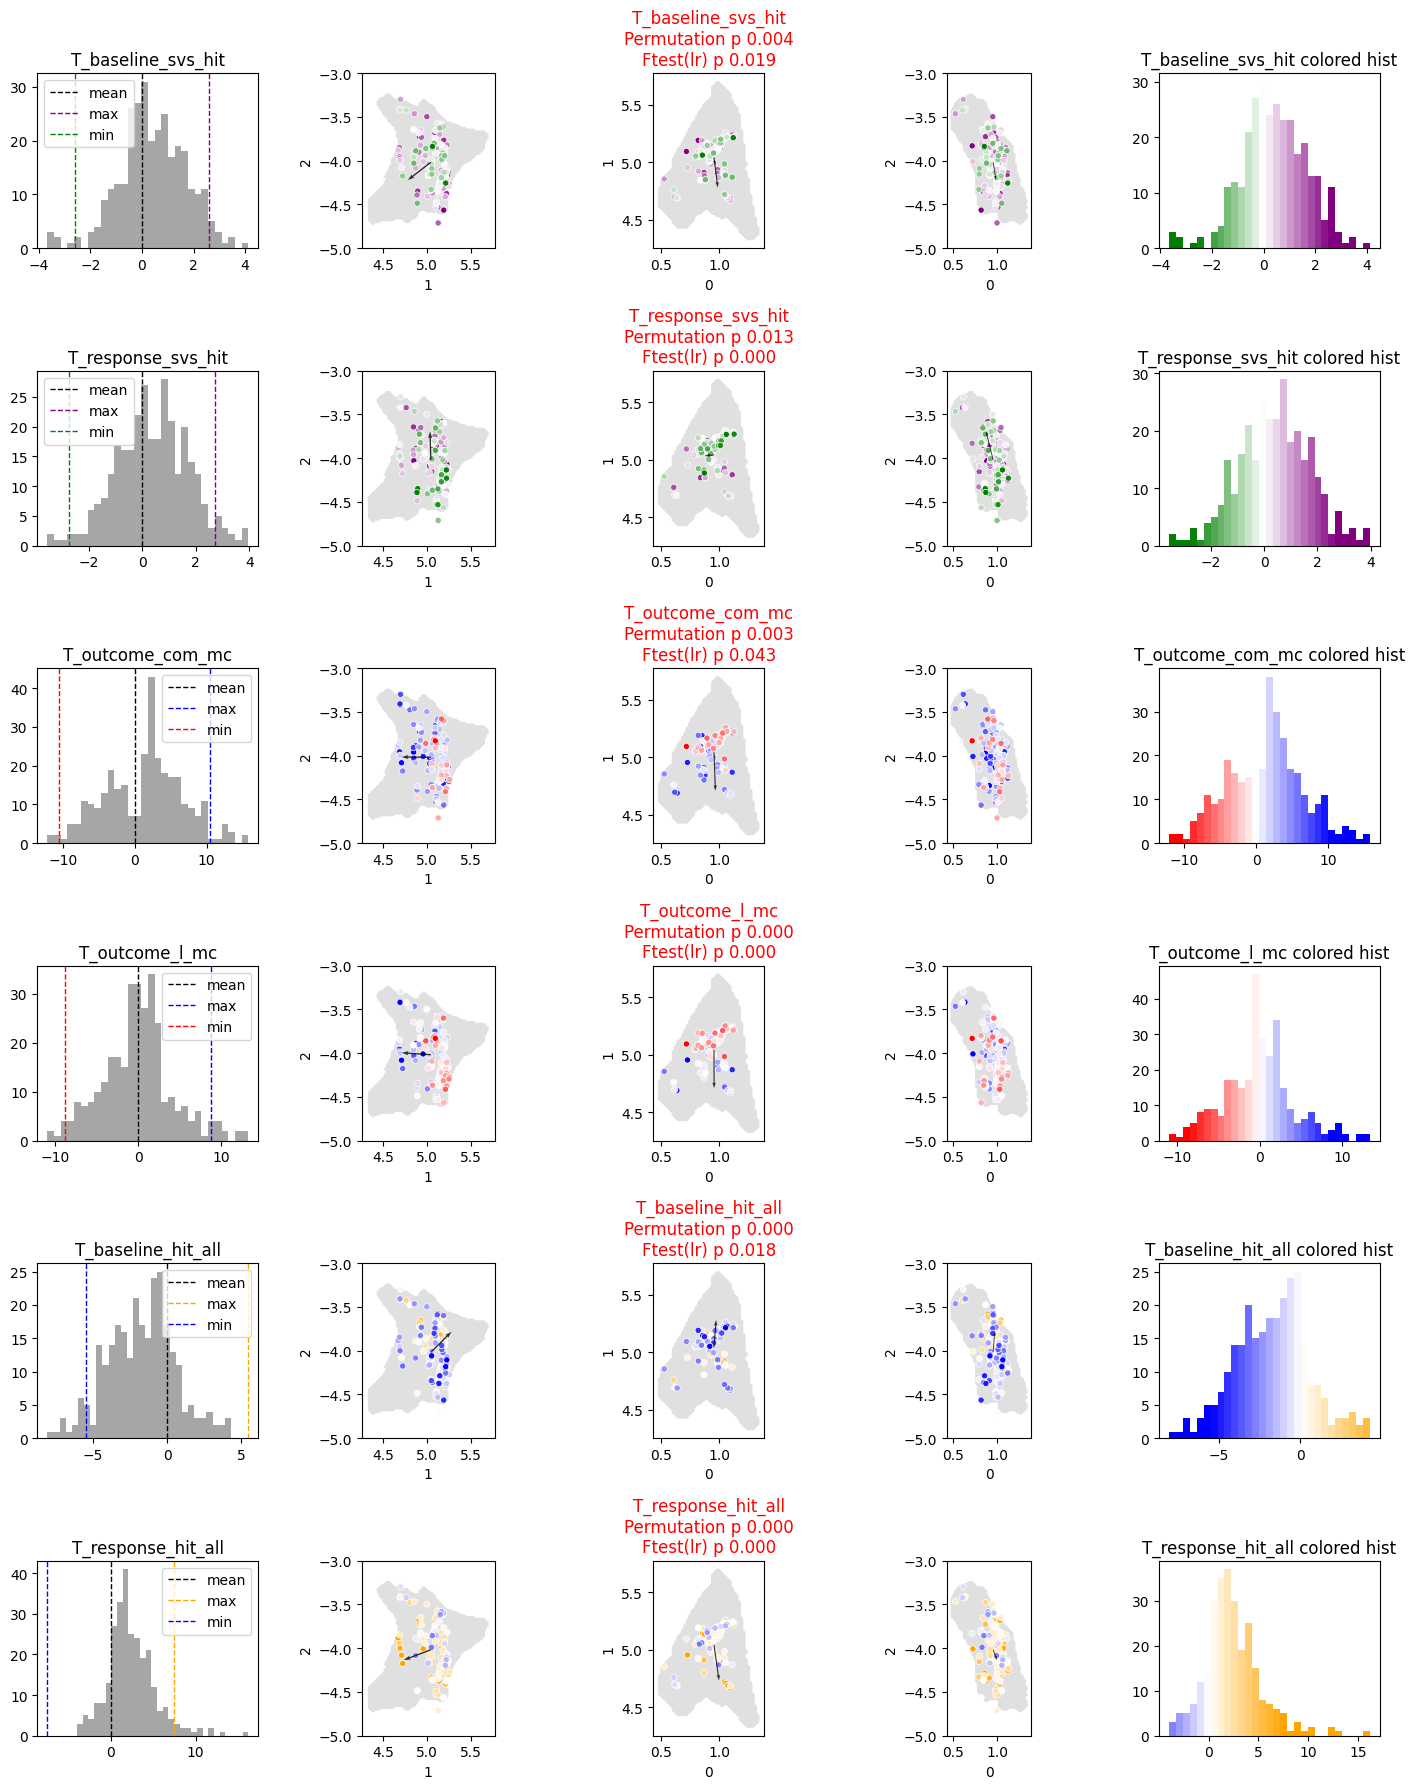

In [88]:
mask = features_combined['be_filter'].values

# --- 3D anatomical points ---
ccfs = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values
bregma_LPS_mm = np.array([-5.7, 5.4, -0.45])  # in mm
ccfs = ccfs - bregma_LPS_mm
ml, ap, dv = 0, 1, 2
ccfs[:, ml] = np.abs(ccfs[:, ml])  # mirror ML to left hemisphere

fig, axes = plt.subplots(len(feature_map.keys()), 5, figsize=(14, 3 * len(feature_map.keys())))
axes = np.atleast_2d(axes)

for ind, feature, colormap in zip(range(len(feature_map.keys())), feature_map.keys(), feature_map.values()):
    color = features_combined[feature].values.astype(float)
    color_reg = color.copy()

    # === Normalize colors to 0–1 ===
    amp_cut = np.nanquantile(np.abs(color_reg), 0.95)
    color_reg = 0.5 + 0.5 * color_reg / amp_cut
    color_reg = np.clip(color_reg, 0, 1)
    center_line = 0
    upper_limit = amp_cut
    lower_limit = -amp_cut

    # color_reg[np.isnan(color_reg)] = 0.5

    # === Histogram of feature values ===
    ax_hist = axes[ind, 0]
    ax_hist.hist(features_combined[feature].values, bins=30, color='gray', alpha=0.7)
    ax_hist.set_title(feature)
    ax_hist.axvline(center_line, color='k', linestyle='--', linewidth=1, label='mean')
    ax_hist.axvline(upper_limit, color=colormap(1.0), linestyle='--', linewidth=1, label = 'max')
    ax_hist.axvline(lower_limit, color=colormap(0.0), linestyle='--', linewidth=1, label = 'min')
    ax_hist.legend()

    # === Sort and filter ===
    sort_ind = np.argsort(color_reg[mask])[::-1]
    ccfs_plot = ccfs[mask][sort_ind]
    color_reg_plot = color_reg[mask][sort_ind]
    # sorted df
    features_combined_sorted = features_combined[mask].iloc[sort_ind]

    # === Precompute RGBA facecolors ===
    rgba_colors = colormap(color_reg_plot)
    rgba_colors[:, -1] = 1  # fixed alpha

    # === 2D plane projections ===
    for plane, ax in zip(planes.keys(), axes[ind, 1:]):
        # background mesh outline
        # ax.scatter(
        #     mesh_vertices_mm[:, planes[plane][0]],
        #     mesh_vertices_mm[:, planes[plane][1]],
        #     color='k', alpha=0.4, s=0.05, edgecolors='none'
        # )
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.7, linewidth=0)

        # scatter the points (alpha-scaled)
        # only plot those not NaN
        sc = ax.scatter(
            ccfs_plot[:, planes[plane][0]][~np.isnan(color_reg_plot)],
            ccfs_plot[:, planes[plane][1]][~np.isnan(color_reg_plot)],
            facecolors=rgba_colors[~np.isnan(color_reg_plot)],
            edgecolors=[1, 1, 1],
            s=20,
            linewidths=0.5,
        )

        # add estimated arrow from linear trend
        coef = spatial_dependence_results[feature]['linear_trend']['coef_const_x_y_z']
        arrow_start = np.nanmean(ccfs, axis=0)
        arrow_vec = np.array([coef[1], coef[2], coef[3]])/np.linalg.norm([coef[1], coef[2], coef[3]])
        ax.quiver(
            arrow_start[planes[plane][0]],
            arrow_start[planes[plane][1]],
            arrow_vec[planes[plane][0]],
            arrow_vec[planes[plane][1]],
            angles='xy', scale_units='xy', scale=3,
            color='k', width=0.01, alpha=0.8
        )

        if plane == 'hor':
            if spatial_dependence_results[feature]['cv_predictability_knn']['significant_fdr']:
                title_color = 'red'
            else:
                title_color = 'black'
            ax.set_title(
                f"{feature}\n"
                f"Permutation p {spatial_dependence_results[feature]['cv_predictability_knn']['p_value_permutation_fdr']:.3f}\n"
                f"Ftest(lr) p {spatial_dependence_results[feature]['linear_trend']['p_value_F_test_vs_intercept_only_fdr']:.3f}",
                color=title_color
            )

        ax.set_xlabel(planes[plane][0])
        ax.set_ylabel(planes[plane][1])
        ax.set_aspect('equal')

        if planes[plane][1] == dv:
            ax.set_ylim([-5, -3])
        
        ax_hist_color = axes[ind, -1]
        # make colored histogram with each bin colored according to the colormap
        edges = np.linspace(np.nanmin(features_combined[feature].values), np.nanmax(features_combined[feature].values), 30)
        # colors and counts of each bin
        bin_centers = 0.5 * (edges[:-1] + edges[1:])
        bin_colors = colormap(0.5 + 0.5 * bin_centers / amp_cut)
        bin_colors = np.clip(bin_colors, 0, 1)
        counts = np.histogram(features_combined[feature].values, bins=edges)[0]
        for i in range(len(edges) - 1):
            ax_hist_color.bar(bin_centers[i], counts[i], width=edges[1] - edges[0], color=bin_colors[i], alpha=1)
        ax_hist_color.set_title(f'{feature} colored hist')


plt.tight_layout()
for ext in ['pdf', 'png', 'svg']:
    plt.savefig(os.path.join(target_folder, f'model_combined_spatial_{criteria_name}.{ext}'),
                bbox_inches='tight', dpi=300)
# plt.close()


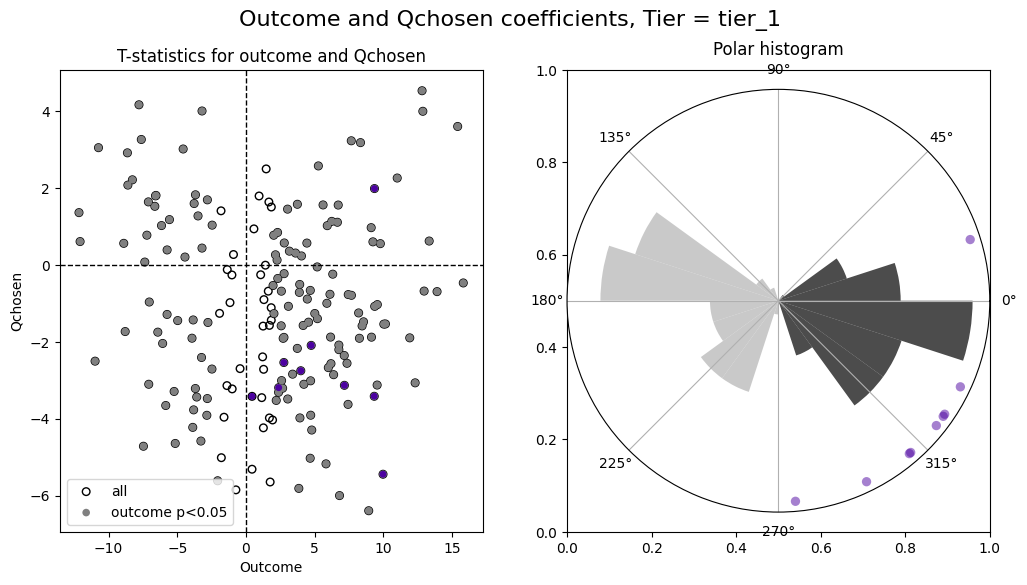

In [104]:
period = 'com'
verion = 'ori'  # 'ori' or 'mc'
c_or_t = 'T'
tier = 'tier_1'
thresh = 0.05
filter = features_combined['be_filter'].values
filter = np.array(filter, dtype=bool)
filter = filter & (features_combined['bl_mean'].values >= 2)

curr_p_int = features_combined[f'p_outcome:ipsi_{period}_{verion}'].values
curr_coefs_int = features_combined[f'coef_outcome:ipsi_{period}_{verion}'].values 
curr_T_int = features_combined[f'T_outcome:ipsi_{period}_{verion}'].values 

curr_coefs_outcome = features_combined[f'coef_outcome_{period}_{verion}'].values[filter]
curr_coefs_q = features_combined[f'coef_Qchosen_{period}_{verion}'].values[filter]

curr_T_outcome = features_combined[f'T_outcome_{period}_{verion}'].values[filter]  # get the T-statistics for the reward outcome
curr_T_q = features_combined[f'T_Qchosen_{period}_{verion}'].values[filter]  # get the T-statistics for the Qchosen
curr_p_outcome = features_combined[f'p_outcome_{period}_{verion}'].values[filter]  # get the p-values for the reward outcome
# scatter of outcome and Qchosen coefficients
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
outcome_T_all = curr_T_outcome
qchosen_T_all = curr_T_q
outcome_coef_all = curr_coefs_outcome
qchosen_coef_all = curr_coefs_q
outcome_P_all = curr_p_outcome

axes[0].scatter(outcome_T_all, qchosen_T_all, color='none', edgecolors='k', s=30, label = 'all')
axes[0].scatter(outcome_T_all[outcome_P_all<thresh], qchosen_T_all[curr_p_outcome<thresh], color='gray', edgecolors='none', s=30, label = 'outcome p<0.05')
# axes[0].scatter(outcome_T_all[outcome_P_all>=thresh], qchosen_T_all[curr_p_outcome>=thresh], color='none', edgecolors='lightgray', s=30, label = 'outcome p>=0.05')
axes[0].set_xlabel('Outcome')
axes[0].set_ylabel('Qchosen')
axes[0].set_title('T-statistics for outcome and Qchosen')
axes[0].axhline(0, color='k', linestyle='--', linewidth=1)
axes[0].axvline(0, color='k', linestyle='--', linewidth=1)
axes[0].legend()

# polar
edges = np.linspace(-np.pi, np.pi, 4*5+1)
axes[1] = fig.add_subplot(122, polar=True)
all_vec = np.column_stack((outcome_coef_all[outcome_P_all<thresh], qchosen_coef_all[outcome_P_all<thresh]))  # combine the coefficients for the reward outcome and Qchosen
# Convert Cartesian coordinates to polar coordinates
cat_mask = outcome_coef_all[outcome_P_all<thresh]>0
# Create polar histogram
# positive
theta, rho = np.arctan2(all_vec[~cat_mask, 1], all_vec[~cat_mask, 0]), np.hypot(all_vec[~cat_mask, 1], all_vec[~cat_mask, 0])
axes[1].hist(theta, bins=edges, color=[0.7, 0.7, 0.7], alpha=0.7, edgecolor='none', density=True)
# negative
theta, rho = np.arctan2(all_vec[cat_mask, 1], all_vec[cat_mask, 0]), np.hypot(all_vec[cat_mask, 1], all_vec[cat_mask, 0])
axes[1].hist(theta, bins=edges, color=[0, 0, 0], alpha=0.7, edgecolor='none', density=True)
axes[1].set_yticks([])
axes[1].set_title('Polar histogram')
# antidromic ones:
mask = (features_combined[tier].astype(bool)) & (features_combined['be_filter'])
curr_coefs_outcome_anti = features_combined[f'coef_outcome_{period}_{verion}'].values[mask]
curr_T_outcome_anti = features_combined[f'T_outcome_{period}_{verion}'].values[mask]  # get the T-statistics for the reward outcome
curr_coefs_q_anti = features_combined[f'coef_Qchosen_{period}_{verion}'].values[mask]
curr_T_q_anti = features_combined[f'T_Qchosen_{period}_{verion}'].values[mask]  # get the T-statistics for the Qchosen
new_vec_anti = np.column_stack((curr_coefs_outcome_anti, curr_coefs_q_anti))  # combine the coefficients for the reward outcome and Qchosen
theta, rho = np.arctan2(new_vec_anti[:, 1], new_vec_anti[:, 0]), np.hypot(new_vec_anti[:, 1], new_vec_anti[:, 0])
axes[1].scatter(theta, 0.9 * np.ones_like(theta), color=(76/255, 2/255, 161/255), alpha=0.5, edgecolors='none', s=45)
# axes[1].hist(theta, bins=edges, color='red', alpha=0.7, edgecolor='none', density=True)
axes[0].scatter(curr_T_outcome_anti, curr_T_q_anti, color=(76/255, 2/255, 161/255), edgecolors='none', s=25, label='anti cells')
# set box and axis to be invisible
# axes[1].get_xaxis().set_visible(False)
# axes[1].get_yaxis().set_visible(False)
plt.suptitle(f'Outcome and Qchosen coefficients, Tier = {tier}', fontsize=16)
plt.savefig(os.path.join(target_folder, f'Scatter&polar_outcome_Qchosen_coeffs_{criteria_name}_with_anti_at_{tier}_scatter_p<{thresh}.pdf'), bbox_inches='tight')



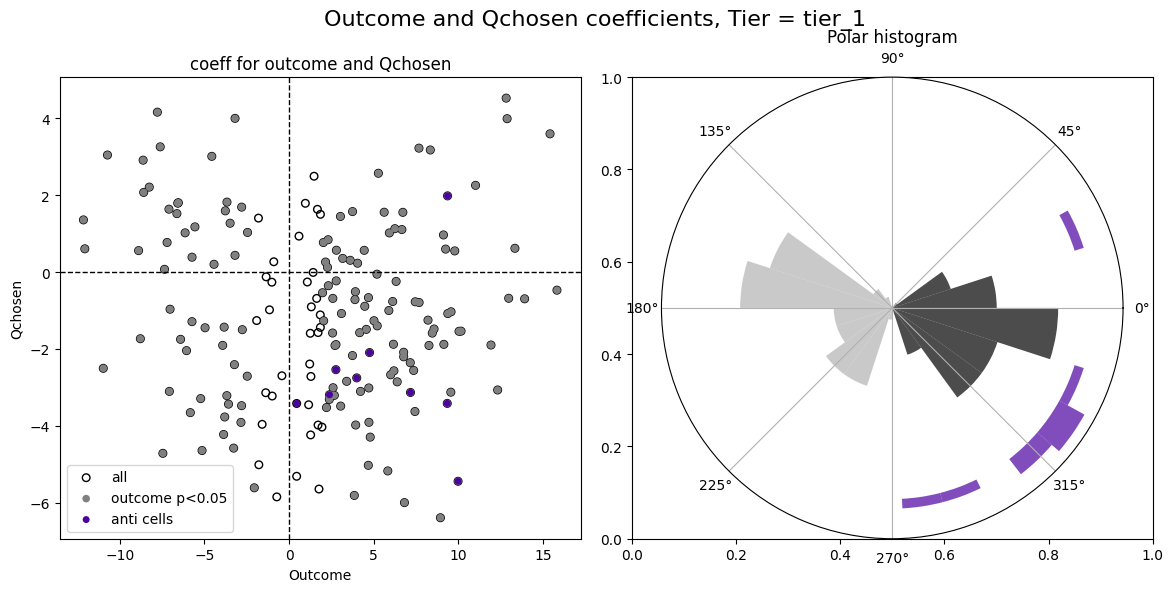

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os

period = 'com'
verion = 'ori'  # 'ori' or 'mc'
c_or_t = 'coeff'
tier = 'tier_1'
thresh = 0.05

# --- filtering ---
filter = np.array(features_combined['be_filter'].values, dtype=bool)
filter = filter & (features_combined['bl_mean'].values >= 2)

# --- coefficients and stats ---
curr_coefs_outcome = features_combined[f'coef_outcome_{period}_{verion}'].values[filter]
curr_coefs_q = features_combined[f'coef_Qchosen_{period}_{verion}'].values[filter]
curr_T_outcome = features_combined[f'T_outcome_{period}_{verion}'].values[filter]
curr_T_q = features_combined[f'T_Qchosen_{period}_{verion}'].values[filter]
curr_p_outcome = features_combined[f'p_outcome_{period}_{verion}'].values[filter]

# --- figure setup ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
outcome_T_all, qchosen_T_all = curr_T_outcome, curr_T_q
outcome_coef_all, qchosen_coef_all = curr_coefs_outcome, curr_coefs_q
outcome_P_all = curr_p_outcome

# === Scatter of T-values ===
axes[0].scatter(outcome_T_all, qchosen_T_all, color='none', edgecolors='k', s=30, label='all')
axes[0].scatter(outcome_T_all[outcome_P_all < thresh], qchosen_T_all[outcome_P_all < thresh],
                color='gray', edgecolors='none', s=30, label=f'outcome p<{thresh}')
axes[0].set_xlabel('Outcome')
axes[0].set_ylabel('Qchosen')
axes[0].set_title(f'{c_or_t} for outcome and Qchosen')
axes[0].axhline(0, color='k', linestyle='--', linewidth=1)
axes[0].axvline(0, color='k', linestyle='--', linewidth=1)
axes[0].legend()

# === Polar histogram (main background) ===
edges = np.linspace(-np.pi, np.pi, 4 * 5 + 1)
axes[1] = fig.add_subplot(122, polar=True)
all_vec = np.column_stack((
    outcome_coef_all[outcome_P_all < thresh],
    qchosen_coef_all[outcome_P_all < thresh]
))
cat_mask = outcome_coef_all[outcome_P_all < thresh] > 0

# positive (gray)
theta_pos = np.arctan2(all_vec[~cat_mask, 1], all_vec[~cat_mask, 0])
axes[1].hist(theta_pos, bins=edges, color=[0.7, 0.7, 0.7],
             alpha=0.7, edgecolor='none', density=True)
# negative (black)
theta_neg = np.arctan2(all_vec[cat_mask, 1], all_vec[cat_mask, 0])
axes[1].hist(theta_neg, bins=edges, color=[0, 0, 0],
             alpha=0.7, edgecolor='none', density=True)

axes[1].set_yticks([])
axes[1].set_title('Polar histogram')

# === Antidromic data (for outer circular histogram) ===
mask = (features_combined[tier].astype(bool)) & (features_combined['be_filter'])
curr_coefs_outcome_anti = features_combined[f'coef_outcome_{period}_{verion}'].values[mask]
curr_coefs_q_anti = features_combined[f'coef_Qchosen_{period}_{verion}'].values[mask]
curr_T_outcome_anti = features_combined[f'T_outcome_{period}_{verion}'].values[mask]
curr_T_q_anti = features_combined[f'T_Qchosen_{period}_{verion}'].values[mask]

new_vec_anti = np.column_stack((curr_coefs_outcome_anti, curr_coefs_q_anti))
theta = np.arctan2(new_vec_anti[:, 1], new_vec_anti[:, 0])

# --- add circular histogram around the edge ---
num_bins = 30+1
counts, bin_edges = np.histogram(theta, bins=num_bins, range=(-np.pi, np.pi), density=False)
counts = counts / counts.max()  # normalize for visualization

color_anti = np.array([76/255, 2/255, 161/255])
r_base = 1.0  # radius of outer circle
r_height = 0.15  # height of histogram bars

# plot bars as radial rectangles
for i in range(num_bins):
    theta_start = bin_edges[i]
    theta_end = bin_edges[i + 1]
    theta_center = 0.5 * (theta_start + theta_end)
    width = theta_end - theta_start
    height = r_height * counts[i]
    axes[1].bar(theta_center, height, width=width,
                bottom=r_base, color=color_anti, alpha=0.7, edgecolor='none', linewidth=0)

# overlay antidromic scatter on T–T plot
axes[0].scatter(curr_T_outcome_anti, curr_T_q_anti,
                color=color_anti, edgecolors='none', s=25, label='anti cells')

plt.suptitle(f'Outcome and Qchosen coefficients, Tier = {tier}', fontsize=16)
axes[0].legend()
plt.tight_layout()
plt.savefig(os.path.join(
    target_folder,
    f'scatter&polar_outcome_Qchosen_coeffs_{criteria_name}_with_anti_at_{tier}_p<{thresh}.pdf'
), bbox_inches='tight')
plt.show()


In [95]:
results_tier1_vs_untier1 = {}
for feature in feature_map.keys():
    result = welch_shift_P_vs_U(
        features_combined[feature].values[filter],
        features_combined['tier_1'].astype(bool).values[filter],
        alternative="two-sided",
        permutations=20000,
        seed=0,
    )

    result_z = binary_shift_P_vs_U(
        (features_combined[feature].values[filter] > 0).astype(int),
        features_combined['tier_1'].astype(bool).values[filter],
        alternative="two-sided",
        permutations=20000,
        seed=0,
    )

    results_tier1_vs_untier1[feature] = {
        "welch_shift": result,
        "binary_shift": result_z,
    }

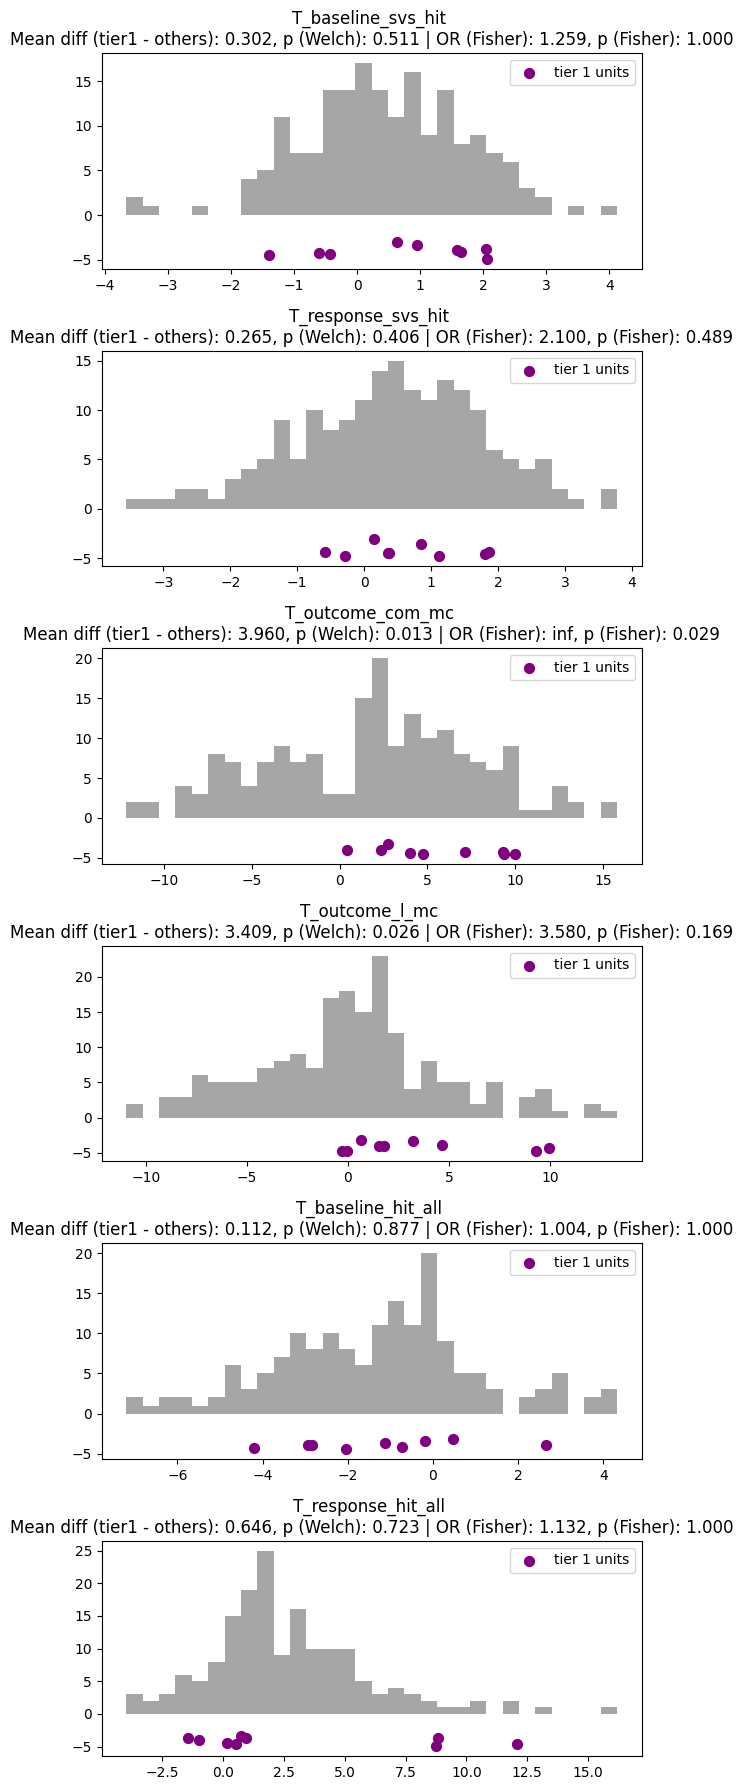

In [102]:
# histogram of all other features with dots of antidromic tier1 units on top
filter = np.array(features_combined['be_filter'].values, dtype=bool)
filter = filter & (features_combined['bl_mean'].values >= 2)
filter = filter & (~features_combined['sd'].isnull())
fig, axes = plt.subplots(len(feature_map.keys()), 1, figsize=(6, 3 * len(feature_map.keys())))
for ind, feature in enumerate(feature_map.keys()):
    ax_hist = axes[ind]
    ax_hist.hist(features_combined[feature].values[filter], bins=30, color='gray', alpha=0.7)
    ax_hist.set_title(feature)

    # antidromic tier 1 units
    tier1_units = features_combined[features_combined['tier_1'].astype(bool) & filter][feature].values
    ax_hist.scatter(tier1_units, np.zeros_like(tier1_units)-5 + np.random.rand(len(tier1_units))*2, color='purple', s=50, label='tier 1 units', zorder=5)
    ax_hist.legend()

    ax_hist.set_title(
        f"{feature} \n"
        f"Mean diff (tier1 - others): {results_tier1_vs_untier1[feature]['welch_shift']['mean_diff_P_minus_U']:.3f}, "
        f"p (Welch): {results_tier1_vs_untier1[feature]['welch_shift']['p_value_permutation']:.3f} | "
        f"OR (Fisher): {results_tier1_vs_untier1[feature]['binary_shift']['odds_ratio_fisher']:.3f}, "
        f"p (Fisher): {results_tier1_vs_untier1[feature]['binary_shift']['p_value_fisher']:.3f}"
    )
# increase spacing
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
# save
plt.savefig(os.path.join(target_folder, f'histograms_features_with_tier1_dots_{criteria_name}.pdf'), bbox_inches='tight')